<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/PET_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [1]:
import os
import glob
import random
import json
import warnings
from collections import defaultdict
from monai.transforms import (EnsureChannelFirstd, Compose, LoadImaged, Spacingd, Resized)
from monai.data import CacheDataset, DataLoader
import numpy as np
import random
from collections import defaultdict
from monai.data import Dataset
from monai.utils import first, set_determinism
import matplotlib.pyplot as plt
import torch
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd


In [2]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
output_dir = config["output_dir"]
artifact_dir = config["artifacts"]
artifact_output = config ["artifact_output"]

## Set dataset path

In [3]:

from data_preparation import ExtrenalRadioSetSetHandling

data_handler = ExtrenalRadioSetSetHandling(artifact_dir, train_mode="NAC", target_mode="MAC")
test_files = data_handler.get_data()

# To access 'image' keys, iterate through the list
image_files = [file_info['image'] for file_info in test_files]
target_files = [file_info['target'] for file_info in test_files]
print(len(image_files))


199


-------------
# Reset THe header

In [ ]:
# import nibabel as nib
# import os

# def reset_origin_and_save(image_paths):
#     for image_path in image_paths:
#         try:
#             img = nib.load(image_path)
#             img_data = img.get_fdata()
#             new_affine = img.affine.copy()
#             new_affine[:3, 3] = 0
#             new_affine[1, 1] = -abs(new_affine[1, 1])
#             new_img = nib.Nifti1Image(img_data, new_affine, header=img.header)
#             new_image_path = image_path #.replace('.nii', '_origin_reset.nii').replace('.gz', '_origin_reset.gz')
#             nib.save(new_img, new_image_path)
#             print(f"Processed: {image_path}")
#         except Exception as e:
#             print(f"Failed to process {image_path}: {e}")

# reset_origin_and_save(image_files)
# reset_origin_and_save(target_files)


In [ ]:
# import nibabel as nib
# import numpy as np
# import os

# def save_image_with_new_header(image_paths):
#     for image_path in image_paths:
#         # Load the original image
#         img = nib.load(image_path)
#         img_data = img.get_fdata()
#         print(f"Original affine matrix for {os.path.basename(image_path)}:\n{img.affine}\n")

#         new_affine = img.affine.copy()
#         new_affine[:3, 3] = 0  # Set the translation part of the affine matrix to 0
        
#         # Create a new NIfTI image with the updated affine matrix
#         new_img = nib.Nifti1Image(img.get_fdata(), new_affine, header=img.header)
        
#         # Save the new image
#         new_image_path = image_path.replace('.nii.gz', 'reset.nii.gz')
#         nib.save(new_img, new_image_path)
        
#         # Print the updated affine matrix
#         print(f"Updated affine matrix for {os.path.basename(new_image_path)}:\n{new_img.affine}\n")

# # Resetting the origin and affine matrix for images
# save_image_with_new_header(image_files)
# save_image_with_new_header(target_files)


-----------------

# Data Visualization

In [4]:
test_name = [(os.path.splitext(os.path.splitext(os.path.basename(file_info['image']))[0])[0], 
              os.path.splitext(os.path.splitext(os.path.basename(file_info['target']))[0])[0]) 
             for file_info in test_files]
test_name

[('001040_C1_RZ_', '001040_C1_RZ_'),
 ('001062_C1_RZ_', '001062_C1_RZ_'),
 ('001418_C1_RZ_', '001418_C1_RZ_'),
 ('001419_C1_RZ_', '001419_C1_RZ_'),
 ('001434_C1_RZ_', '001434_C1_RZ_'),
 ('001447_C1_RZ_', '001447_C1_RZ_'),
 ('001453_C1_RZ_', '001453_C1_RZ_'),
 ('001454_C1_RZ_', '001454_C1_RZ_'),
 ('001468_C1_RZ_', '001468_C1_RZ_'),
 ('001470_C1_RZ_', '001470_C1_RZ_'),
 ('001477_C1_RZ_', '001477_C1_RZ_'),
 ('001487_C1_RZ_', '001487_C1_RZ_'),
 ('001502_C1_RZ_', '001502_C1_RZ_'),
 ('001504_C1_RZ_', '001504_C1_RZ_'),
 ('001510_C1_RZ_', '001510_C1_RZ_'),
 ('001525_C1_RZ_', '001525_C1_RZ_'),
 ('001555_C1_RZ_', '001555_C1_RZ_'),
 ('001564_C1_RZ_', '001564_C1_RZ_'),
 ('001572_C1_RZ_', '001572_C1_RZ_'),
 ('001575_C1_RZ_', '001575_C1_RZ_'),
 ('001582_C1_RZ_', '001582_C1_RZ_'),
 ('001583_C1_RZ_', '001583_C1_RZ_'),
 ('001585_C1_RZ_', '001585_C1_RZ_'),
 ('001598_C1_RZ_', '001598_C1_RZ_'),
 ('001599_C1_RZ_', '001599_C1_RZ_'),
 ('001600_C1_RZ_', '001600_C1_RZ_'),
 ('001601_C1_RZ_', '001601_C1_RZ_'),
 

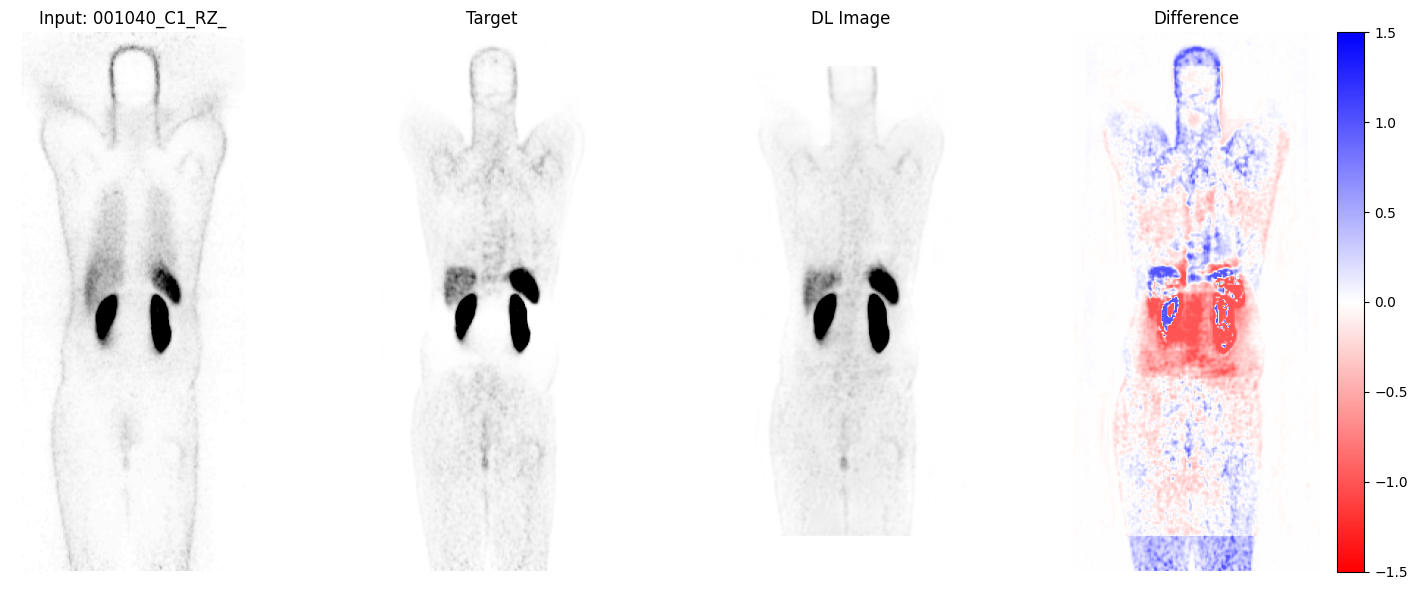

In [16]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

def apply_window(image, window_level, window_width):
    """
    Apply window level and width to an image.

    Parameters:
    - image: The input image as a NumPy array.
    - window_level (WL): The center of the range of interest.
    - window_width (WW): The width of the range of interest.

    Returns:
    - The windowed image.
    """
    lower_bound = window_level - window_width / 2
    upper_bound = window_level + window_width / 2
    windowed_image = np.clip(image, lower_bound, upper_bound)
    windowed_image = (windowed_image - lower_bound) / window_width
    return windowed_image

window_level = 0  # Example values
window_width = 1  # Example values



# Function to find the DL image path for a given patient folder name
def find_dl_image_path(patient_folder_name):
    # Construct a glob pattern to search for DL images with the matching patient folder name
    search_pattern = os.path.join(artifact_output, "**", f"{patient_folder_name}*.nii.gz")
    found_paths = glob.glob(search_pattern, recursive=True)
    if found_paths:
        return found_paths[0]  # Return the first match
    else:
        return None  # No match found

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
cmap = LinearSegmentedColormap.from_list(
    'blue_white_red', 
    ['red', 'white', 'blue']
)
# Loop over each file pair, find the matching DL image, and plot them
for file_info, name_pair in zip(test_files, test_name):
    image_path = file_info['image']
    target_path = file_info['target']
    patient_folder_name_image, _ = name_pair

    dl_image_path = find_dl_image_path(patient_folder_name_image)
    if dl_image_path is None:
        print(f"No DL image found for {patient_folder_name_image}")
        continue

    # Load and normalize images
    # image = normalize_data(nib.load(image_path).get_fdata())
    # target = normalize_data(nib.load(target_path).get_fdata())
    # dl_image = normalize_data(nib.load(dl_image_path).get_fdata())
    # windowed_image = apply_window(image, window_level, window_width)
    # # Calculate the difference image and normalize to range -1 to 1
    # difference_image = target - dl_image
    # difference_image = np.clip(difference_image, -1, 1)  # Ensure the difference is within -1 to 1

    # difference_image = 2 * (difference_image - np.min(difference_image)) / (np.max(difference_image) - np.min(difference_image)) - 1

    image = nib.load(image_path).get_fdata()
    target = nib.load(target_path).get_fdata()
    dl_image = nib.load(dl_image_path).get_fdata()
    difference_image = target - dl_image
    difference_image = np.clip(difference_image, -1, 1)  # Ensure the difference is within -1 to 1
    n = 94

    fig, axs = plt.subplots(1, 4, figsize=(15, 6))

    plt.subplot(1, 4, 1)
    plt.title(f"Input: {patient_folder_name_image}")
    input_slice = np.rot90(image[:, n, :])
    plt.imshow(input_slice, cmap="gist_yarg", vmin=0, vmax=0.07)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Target")
    input_slice = np.rot90(target[:, n, :])
    plt.imshow(input_slice, cmap="gist_yarg", vmin=0, vmax=7)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("DL Image")
    input_slice = np.rot90(dl_image[:, n, :])
    plt.imshow(input_slice, cmap="gist_yarg", vmin=0, vmax=7)
    plt.axis('off')

    ax = plt.subplot(1, 4, 4)
    plt.subplot(1, 4, 4)
    plt.title("Difference")
    # Using a diverging colormap to highlight differences
    difference_display = plt.imshow(np.rot90(difference_image[:, n, :]), cmap=cmap, vmin=-1.5, vmax=1.5) # vmin=-np.max(np.abs(difference_image)), vmax=np.max(np.abs(difference_image)))
    plt.axis('off')
    fig.colorbar(difference_display, ax=axs[3])

    plt.tight_layout()
    plt.show()
    break


In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from matplotlib.colors import LinearSegmentedColormap


# Function to find the DL image path for a given patient folder name
def find_dl_image_path(patient_folder_name):
    # Construct a glob pattern to search for DL images with the matching patient folder name
    search_pattern = os.path.join(artifact_output, "**", f"{patient_folder_name}*.nii.gz")
    found_paths = glob.glob(search_pattern, recursive=True)
    if found_paths:
        return found_paths[0]  # Return the first match
    else:
        return None  # No match found

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
cmap = LinearSegmentedColormap.from_list(
    'blue_white_red', 
    ['red', 'white', 'blue']
)
# Loop over each file pair, find the matching DL image, and plot them
for file_info, name_pair in zip(test_files, test_name):
    image_path = file_info['image']
    target_path = file_info['target']
    patient_folder_name_image, _ = name_pair

    dl_image_path = find_dl_image_path(patient_folder_name_image)
    if dl_image_path is None:
        print(f"No DL image found for {patient_folder_name_image}")
        continue

    # Load and normalize images
    image = normalize_data(nib.load(image_path).get_fdata())
    target = normalize_data(nib.load(target_path).get_fdata())
    dl_image = normalize_data(nib.load(dl_image_path).get_fdata())
    
    # Calculate the difference image and normalize to range -1 to 1
    difference_image = target - dl_image
    # difference_image = 2 * (difference_image - np.min(difference_image)) / (np.max(difference_image) - np.min(difference_image)) - 1

    
    n = 94

    fig, axs = plt.subplots(1, 4, figsize=(15, 6))

    plt.subplot(1, 4, 1)
    plt.title(f"Input: {patient_folder_name_image}")
    input_slice = np.rot90(image[:, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Target")
    input_slice = np.rot90(target[:, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("DL Image")
    input_slice = np.rot90(dl_image[:, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")
    plt.axis('off')

    ax = plt.subplot(1, 4, 4)
    plt.subplot(1, 4, 4)
    plt.title("Difference")
    # Using a diverging colormap to highlight differences
    difference_display = plt.imshow(np.rot90(difference_image[:, n, :]), cmap=cmap, vmin=-np.max(np.abs(difference_image)), vmax=np.max(np.abs(difference_image))) # , vmin=-1, vmax=1) #
    plt.axis('off')
    fig.colorbar(difference_display, ax=ax, shrink=0.6)

    plt.tight_layout()
    plt.show()
    # break
# "seismic""bwr"


In [ ]:
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import exposure

from skimage import exposure, img_as_float

def load_and_normalize_nifti(path):
    """Load a NIFTI file and normalize its data."""
    img = nib.load(path).get_fdata()
    img = img_as_float(img)  # Normalize image to float in the range [0, 1]
    return img

for file_info, name_pair in zip(test_files, test_name):
    image_path = file_info['image']
    target_path = file_info['target']

    # Load and normalize images
    image = load_and_normalize_nifti(image_path)
    target = load_and_normalize_nifti(target_path)

    # Extract the patient folder name from the file path
    patient_folder_name_image, patient_folder_name_target = name_pair
    # Let's say you want to display the middle slice for each image/target
    n = image.shape[0] // 2  # Assuming the third dimension is the 'slice' dimension

    plt.figure(figsize=(7, 12))  # Correct way to set figure size
    plt.subplot(1, 2, 1)
    plt.title(f"{patient_folder_name_image}")
    # Rotate the slice and plot
    input_slice = np.rot90(image[:, n, :])
    plt.imshow(input_slice, cmap="BuPu")

    plt.subplot(1, 2, 2)
    plt.title(f"{patient_folder_name_target}")
    # Rotate the slice and plot
    target_slice = np.rot90(target[:, n, :])
    plt.imshow(target_slice, cmap='BuPu')

    plt.show()
    # Display the plot
    plt.show()




In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]

# Assuming you have two lists `image_files` and `target_files` which contain file paths to the images and targets, respectively
for image_path, target_path in zip(image_files, target_files):
    image = nib.load(image_path).get_fdata()
    target = nib.load(target_path).get_fdata()
    patient_folder_name = os.path.basename(os.path.dirname(image_path))

    # Let's say you want to display the middle slice for each image/target
    n = image.shape[0] // 2  # Assuming the third dimension is the 'slice' dimension

    plt.figure(figsize=(6, 12))  # Correct way to set figure size
    plt.subplot(1, 2, 1)
    plt.title(f"{patient_folder_name} - Input")
    # Rotate the slice and plot
    input_slice = np.rot90(image[:, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 2, 2)
    plt.title(f"{patient_folder_name} - Ground truth")
    # Rotate the slice and plot
    target_slice = np.rot90(target[:, n, :])
    plt.imshow(target_slice, cmap='gist_yarg')

    plt.show()
    



-------

# The Image Dimension

In [ ]:
from monai.transforms import LoadImage

loader = LoadImage(image_only=True)

# Iterate through each pair of image and target
for image_path, target_path in zip(image_files, target_files):
    # Load the image and target
    image = loader(image_path)
    target = loader(target_path)
    
    # Print the size information of the image and target
    print(f"Image Size: {image.shape},  {image_path},")
    print(f"Target Size: {target.shape}, {target_path},\n")


In [ ]:
from monai.transforms import LoadImage
import matplotlib.pyplot as plt

# Assuming val_files is a list of dictionaries with 'image' keys
image_sizes = []
loader = LoadImage(image_only=True)

# Collect image sizes
for file_info in image_files:
    image = loader(file_info)
    image_sizes.append(image.shape)

# Extracting dimensions
dims1 = [size[0] for size in image_sizes]
dims2 = [size[1] for size in image_sizes]
dims3 = [size[2] for size in image_sizes]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].hist(dims1, bins=20, color='skyblue')
axs[0].set_title('Dimension 1 Sizes')
axs[0].set_xlabel('Size')
axs[0].set_ylabel('Frequency')

axs[1].hist(dims2, bins=20, color='lightgreen')
axs[1].set_title('Dimension 2 Sizes')
axs[1].set_xlabel('Size')

axs[2].hist(dims3, bins=20, color='salmon')
axs[2].set_title('Dimension 3 Sizes')
axs[2].set_xlabel('Size')

plt.tight_layout()
plt.show()


In [ ]:
# def print_image_info(file_info, transforms):
#     loader = LoadImage(image_only=True)
#     image = loader(file_info['image'])
#     print(f"Original image size: {image.shape}")
    
#     # Apply transformations
#     transformed_image = transforms(file_info)
#     print(f"Transformed image size: {transformed_image['image'].shape}")

# # Define your transforms
# train_transforms = Compose([
#     LoadImaged(keys=["image", "target"]),
#     EnsureChannelFirstd(keys=["image", "target"]),
#     Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
#     SpatialPadd(keys=["image", "target"], spatial_size=[96, 96, 96], mode='constant', method='symmetric'),
# ])

# # # Example usage
# # print("Train Files:")
# # for file_info in train_files[-5:]:  # Adjust the number as needed
# #     print_image_info(file_info, train_transforms)

# print("\nValidation Files:")
# for file_info in val_files[-5:]:  # Adjust the number as needed
#     print_image_info(file_info, train_transforms)


-------------
# Check voxel spacing

In [ ]:
from monai.transforms import LoadImage
import numpy as np

def get_voxel_spacing(file_path):
    loader = LoadImage(image_only=False)  # Load image and metadata
    _, meta_data = loader(file_path)
    # The first element of 'pixdim' is often 1 and not used for spacing,
    # so we take the next three elements which represent the voxel spacings in X, Y, and Z.
    spacing = meta_data['pixdim'][1:4]  # Extract voxel spacing from 'pixdim'
    return spacing


voxel_spacings = np.array([get_voxel_spacing(file_info) for file_info in image_files])

print(voxel_spacings)





In [ ]:
from monai.transforms import LoadImage
import numpy as np
import warnings  # To issue warnings


def check_voxel_spacing_mismatch(image_files, target_files):
    if len(image_files) != len(target_files):
        raise ValueError("Number of image files and target files must be the same.")
    
    for i, (image_path, target_path) in enumerate(zip(image_files, target_files)):
        image_spacing = get_voxel_spacing(image_path)
        target_spacing = get_voxel_spacing(target_path)
        
        if not np.allclose(image_spacing, target_spacing):
            warnings.warn(f"Voxel spacing mismatch between image and target at index {i}: {image_path} vs {target_path}")



check_voxel_spacing_mismatch(image_files, target_files)

In [ ]:
# Assuming voxel_spacings is an Nx3 array where N is the number of images, and each row is the spacing (x, y, z)
plt.figure(figsize=(15, 5))

# X dimension spacings
plt.subplot(1, 3, 1)
plt.hist(voxel_spacings[:, 0], bins=50, color='r')
plt.title('Histogram of X dimension spacings')
plt.xlabel('Spacing')
plt.ylabel('Frequency')

# Y dimension spacings
plt.subplot(1, 3, 2)
plt.hist(voxel_spacings[:, 1], bins=50, color='g')
plt.title('Histogram of Y dimension spacings')
plt.xlabel('Spacing')

# Z dimension spacings
plt.subplot(1, 3, 3)
plt.hist(voxel_spacings[:, 2], bins=50, color='b')
plt.title('Histogram of Z dimension spacings')
plt.xlabel('Spacing')

plt.tight_layout()
plt.show()


In [ ]:
# Create the data for the circle plots based on the unique values and their counts
x_spacing_counts = np.unique(voxel_spacings[:, 0], return_counts=True)
y_spacing_counts = np.unique(voxel_spacings[:, 1], return_counts=True)
z_spacing_counts = np.unique(voxel_spacings[:, 2], return_counts=True)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# X dimension spacings
axs[0].pie(x_spacing_counts[1], labels=x_spacing_counts[0], autopct='%1.1f%%', startangle=90)
axs[0].set_title('Circle plot of X dimension spacings')

# Y dimension spacings
axs[1].pie(y_spacing_counts[1], labels=y_spacing_counts[0], autopct='%1.1f%%', startangle=90)
axs[1].set_title('Circle plot of Y dimension spacings')

# Z dimension spacings
axs[2].pie(z_spacing_counts[1], labels=z_spacing_counts[0], autopct='%1.1f%%', startangle=90)
axs[2].set_title('Circle plot of Z dimension spacings')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import mode

# Since mode() returns a scalar, we no longer try to index it with [0]
most_common_spacing_x = mode(np.round(voxel_spacings[:, 0], decimals=2)).mode
most_common_spacing_y = mode(np.round(voxel_spacings[:, 1], decimals=2)).mode
most_common_spacing_z = mode(np.round(voxel_spacings[:, 2], decimals=2)).mode

print(f"Most common voxel spacing in X dimension: {most_common_spacing_x}")
print(f"Most common voxel spacing in Y dimension: {most_common_spacing_y}")
print(f"Most common voxel spacing in Z dimension: {most_common_spacing_z}")


-------------
# Test details

In [ ]:
from scipy.stats import mode
test_mode_result_x = mode(np.round(voxel_spacings[:, 0], decimals=2))
print("Mode Result X:", test_mode_result_x)
print("Mode X:", test_mode_result_x.mode)


In [ ]:
print("Mode Result X Shape:", test_mode_result_x.mode.shape)
print("Type of Mode Result X:", type(test_mode_result_x.mode))


In [ ]:
print("Voxel Spacings Shape:", voxel_spacings.shape)
print("Type of Voxel Spacings:", type(voxel_spacings))


In [ ]:
print("First Element:", voxel_spacings[0, :])


In [ ]:
most_common_spacing_x = np.round(voxel_spacings[:, 0], decimals=2)
mode_result_x = mode(most_common_spacing_x)
print("Most Common Spacing X:", mode_result_x.mode if mode_result_x.mode.size else "No mode found")


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


----------
# Pixel Values

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage

# Initialize a list to store all pixel values
all_pixel_values = []

# Assuming 'data_files' is a list of file paths for your dataset
for file_path in image_files:
    # Load the image
    image = LoadImage(image_only=True)(file_path)
    
    # Convert the image to a numpy array if it's not already
    image_np = np.array(image)
    
    # Flatten the image array to get a list of all pixel values in the image
    pixels = image_np.flatten()
    
    # Append these pixel values to the aggregate list
    all_pixel_values.extend(pixels)

# Convert the list of all pixel values to a numpy array
all_pixel_values_np = np.array(all_pixel_values)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_pixel_values_np contains all the pixel values from the dataset

# Calculate mean and max of the scaled pixel values
mean_value = np.mean(all_pixel_values_np)
max_value = np.max(all_pixel_values_np)

# Printing statistical information
print(f"Mean of scaled pixel values: {mean_value}")
print(f"Maximum of scaled pixel values: {max_value}")

# Plotting the histogram of scaled pixel values
plt.figure(figsize=(10, 6))
plt.hist(all_pixel_values_np, bins=50, color='green', alpha=0.7, density=True)
plt.title("Histogram of Scaled Pixel Values across the Dataset")
plt.xlabel("Scaled Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage


# Initialize LoadImage transform
loader = LoadImage(image_only=True)

for file_path in target_files:
    # Load the image
    image = loader(file_path)
    
    # Convert the image to a numpy array if it's not already
    image_np = np.array(image)
    
    # Calculate mean and max of the pixel values for the current image
    mean_value = np.mean(image_np)
    max_value = np.max(image_np)
    
    # Printing statistical information for each image
    print(f"File: {file_path}")
    print(f"Mean of pixel values: {mean_value}")
    print(f"Maximum of pixel values: {max_value}\n")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage

# Initialize a list to store all pixel values
all_pixel_values = []

# Assuming 'data_files' is a list of file paths for your dataset
for file_path in target_files:
    # Load the image
    image = LoadImage(image_only=True)(file_path)
    
    # Convert the image to a numpy array if it's not already
    image_np = np.array(image)
    
    # Flatten the image array to get a list of all pixel values in the image
    pixels = image_np.flatten()
    
    # Append these pixel values to the aggregate list
    all_pixel_values.extend(pixels)

# Convert the list of all pixel values to a numpy array
all_pixel_values_np = np.array(all_pixel_values)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_pixel_values_np contains all the pixel values from the dataset

# Calculate mean and max of the scaled pixel values
mean_value = np.mean(all_pixel_values_np)
max_value = np.max(all_pixel_values_np)

# Printing statistical information
print(f"Mean of scaled pixel values: {mean_value}")
print(f"Maximum of scaled pixel values: {max_value}")

# Plotting the histogram of scaled pixel values
plt.figure(figsize=(10, 6))
plt.hist(all_pixel_values_np, bins=50, color='green', alpha=0.7, density=True)
plt.title("Histogram of Scaled Pixel Values across the Dataset/ target")
plt.xlabel("Scaled Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

# Assuming you have two lists `image_files` and `target_files` which contain file paths to the images and targets, respectively
for image_path, target_path in zip(image_files, target_files):
    image = nib.load(image_path).get_fdata()
    target = nib.load(target_path).get_fdata()
    
    # Let's say you want to display the middle slice for each image/target
    n = image.shape[0] // 2  # Assuming the third dimension is the 'slice' dimension

    plt.figure(figsize=(12, 6))  # Correct way to set figure size
    plt.subplot(1, 2, 1)
    plt.title("Input")
    # Rotate the slice and plot
    input_slice = np.rot90(image[:, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 2, 2)
    plt.title("Ground truth")
    # Rotate the slice and plot
    target_slice = np.rot90(target[:, n, :])
    plt.imshow(target_slice, cmap='gist_yarg')

    plt.show()
    



In [ ]:

import numpy as np

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")


In [ ]:

n = 90  # Selecting the slice

plt.figure(figsize=(12, 6))  # Correct way to set figure size
plt.subplot(1, 2, 1)
plt.title("Input")
# Rotate the slice and plot
input_slice = np.rot90(image[:, n, :])
plt.imshow(input_slice, cmap="gist_yarg")

plt.subplot(1, 2, 2)
plt.title("Ground truth")
# Rotate the slice and plot
target_slice = np.rot90(target[:, n, :])
plt.imshow(target_slice, cmap='gist_yarg')

plt.show()


-------------
# Transformers

In [ ]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd
)


roi_size = [168, 168, 320]

val_transforms = Compose([
    LoadImaged(keys=["image", "target"]),
    EnsureChannelFirstd(keys=["image", "target"]),
    Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00)),  # Adjust spacing as needed
    SpatialPadd(keys=["image", "target"], spatial_size=(200, 200, 350), mode='constant',  method='symmetric'),  # Pad to ensure minimum size
    ScaleIntensityd(keys=["image", "target"], minv=0.0, maxv=1.0),
    CenterSpatialCropd(keys=["image", "target"], roi_size=roi_size),  # Crop to ensure exact size
])




train_ds = CacheDataset(data=train_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=1)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)



In [ ]:
# Load a few sample images from the train_loader and print their sizes
for i, batch_data in enumerate(train_loader):
    images = batch_data["image"]
    print(f"Batch {i} image size: {images.shape}")
    if i == 2:  # Adjust this to inspect more or fewer batches
        break

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from monai.data import DataLoader

# Assuming val_loader is already defined and loaded with your validation data
n = 95  # Selecting the slice

for i, data in enumerate(val_loader):
    image, target = (data["image"][0][0], data["target"][0][0])
    
    # Check if the selected slice index is within the bounds for the current image and target
    if n >= image.shape[1] or n >= target.shape[1]:  # Assuming the second dimension is the slice index
        print(f"Skipping patient {i+1}: slice index {n} is out of bounds for this patient.")
        continue

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Patient {i+1}: Input")
    input_slice = np.rot90(image[:, n, :])  # Adjust the slice index position if needed
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 2, 2)
    plt.title(f"Patient {i+1}: Ground truth")
    target_slice = np.rot90(target[:, n, :])  # Adjust the slice index position if needed
    plt.imshow(target_slice, cmap='gist_yarg')

    plt.show()


------------
# Apply transformers on test data


In [ ]:
# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensity
# from monai.inferers import SlidingWindowInferer

# # Assuming the same spacing and intensity normalization as training
# test_transforms = Compose([
#     LoadImaged(keys=["image"]),
#     EnsureChannelFirstd(keys=["image"]),
#     Spacingd(keys=["image"], pixdim=(4.07, 4.07, 3.0), mode=('bilinear')),
#     ScaleIntensity(keys=["image"]),  # Adjust based on your specific normalization used during training
#     # No need for SpatialPadd or cropping here
# ])

# # Sliding window inferer with the patch size used during training
# inferer = SlidingWindowInferer(roi_size=[96, 96, 96], sw_batch_size=1, overlap=0.5)

# # Assuming `model` is your trained model and `test_data` is a batch from your DataLoader
# test_data = next(iter(test_loader))  # Example to get a batch
# model.eval()
# with torch.no_grad():
#     # Apply transformations
#     test_data_transformed = test_transforms(test_data)
#     # Perform inference
#     preds = inferer(inputs=test_data_transformed["image"].unsqueeze(0), network=model)
#     # preds now contains the prediction for the whole volume


# **Create Model, Loss, Optimizer**

In [ ]:
import json
import torch
from torch import nn
from monai.networks.nets import UNet
from monai.networks.layers import Norm


model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [ ]:
max_epochs = 10
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []

In [ ]:


for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, targets = (batch_data["image"].to(device),
                           batch_data["target"].to(device),)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    train_losses.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_targets = (val_data["image"].to(device),
                                           val_data["target"].to(device),)
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_targets).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            val_losses.append(val_loss)
            print(f"Validation loss: {val_loss:.4f}")

            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_PET.pth"))
                print("Saved new best metric model")

print(f"Training completed. Best validation loss: {best_metric:.4f} at epoch {best_metric_epoch}")


In [ ]:
import numpy as np
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
plt.figure(figsize=(14, 6))  # Set the size of the figure

# Plotting the training and validation losses
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha = 0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 20))

plt.show()

In [ ]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_data["image"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"target")
    plt.imshow(val_data["target"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = val_outputs.detach().cpu()[0, 0, :, :, n]
    plt.imshow(output_slice, cmap="gist_yarg") # "gist_yarg")
    plt.show()


    # Load the best model state for visualization
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_PET.pth")))
model.eval()
roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(val_loader):

        n = 200
        visualize_results(val_data, model, n, f"Best Model")
        if i == 0:
            break




In [ ]:
#         if dice_after > best_eval_dice:
#             best_eval_dice = dice_after
#             if do_save:
#                 # Save best model based on Dice
#                 if pth_best_dice != "":
#                     os.remove(os.path.join(dir_save, pth_best_dice))
#                 pth_best_dice = f"segresnet_kpt_loss_best_dice_{epoch + 1}_{best_eval_dice:.3f}.pth"
#                 torch.save(model.state_dict(), os.path.join(dir_save, pth_best_dice))
#                 print(f"{epoch + 1} | Saving best Dice model: {pth_best_dice}")

#     if do_save:
#         # Save latest model
#         if pth_latest != "":
#             os.remove(os.path.join(dir_save, pth_latest))
#         pth_latest = "segresnet_kpt_loss_latest.pth"
#         torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))


# # learn2reg_nlst_paired_lung_CT notbook